Deep Learning - Prueba Saul
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [ ]:
tf.add()

First reload the data we generated in `1_notmnist.ipynb`.

In [10]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 28, 28) (100000,)
Validation set (5000, 28, 28) (5000,)
Test set (5000, 28, 28) (5000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [11]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (100000, 784) (100000, 10)
Validation set (5000, 784) (5000, 10)
Test set (5000, 784) (5000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [12]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [13]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 18.421494
Training accuracy: 12.8%
Validation accuracy: 12.8%
Loss at step 100: 0.437522
Training accuracy: 95.7%
Validation accuracy: 11.5%
Loss at step 200: 0.243619
Training accuracy: 97.1%
Validation accuracy: 11.1%


KeyboardInterrupt: 

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [14]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [15]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 14.429139
Minibatch accuracy: 12.5%
Validation accuracy: 15.9%
Minibatch loss at step 500: 1.240521
Minibatch accuracy: 88.3%
Validation accuracy: 21.8%
Minibatch loss at step 1000: 0.071556
Minibatch accuracy: 97.7%
Validation accuracy: 27.1%
Minibatch loss at step 1500: 0.424953
Minibatch accuracy: 94.5%
Validation accuracy: 28.8%
Minibatch loss at step 2000: 0.572591
Minibatch accuracy: 97.7%
Validation accuracy: 23.6%
Minibatch loss at step 2500: 0.620691
Minibatch accuracy: 95.3%
Validation accuracy: 25.6%
Minibatch loss at step 3000: 0.209356
Minibatch accuracy: 95.3%
Validation accuracy: 28.7%
Test accuracy: 31.5%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [35]:
#First lets define a fucntion to represent the topology of our Neuronal Network:
#Topology: Multilayer Perceptron, 1 hidden layer with 1024 neurons and RELU activation function.

def mlp(x, weights, biases):
    '''
    x: tf array with the training examples
    weights: dictionary with the tensors containing the weights for each layer
    biases: dictionary with the tensors containing the biases for each layer
    '''
    #h1 layer z = XW + b
    h1_layer = tf.add(tf.matmul(x,weights['h1']), biases['b1'])
    #h1 layer activation function relu(z)
    h1_layer = tf.nn.relu(h1_layer)
    #output layer (no activation needed after output layer)
    out_layer = tf.add(tf.matmul(h1_layer,weights['out']), biases['out'])
    
    #we return the values predicted by the network in the output layer
    return out_layer

# Test 0

batch_size = 128
training_epochs = 3001
learning_rate = 0.5
display_step = 500
n_hidden_1 = 1024

Graph Variables Initialized!
Minibatch loss at step 0: 263.086303711
Minibatch accuracy: 15.625
Validation accuracy: 10.0
Minibatch loss at step 500: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 19.38
Minibatch loss at step 1000: 0.0
Minibatch accuracy: 100.0
Validation accuracy: 19.94
Minibatch loss at step 1500: 0.115932941437
Minibatch accuracy: 98.4375
Validation accuracy: 21.96
Minibatch loss at step 2000: 0.0125381769612
Minibatch accuracy: 99.21875
Validation accuracy: 27.06
Minibatch loss at step 2500: 8.1004447937
Minibatch accuracy: 91.40625
Validation accuracy: 32.54
Minibatch loss at step 3000: 0.155385047197
Minibatch accuracy: 97.65625
Validation accuracy: 29.34
Test accuracy: 33.46



# Test 1

batch_size = 128
training_epochs = 3001
learning_rate = 0.001
display_step = 100
n_hidden_1 = 1024

Graph Variables Initialized!
Minibatch loss at step 0: 378.677947998
Minibatch accuracy: 2.34375
Validation accuracy: 9.3
Minibatch loss at step 500: 30.2137889862
Minibatch accuracy: 84.375
Validation accuracy: 18.84
Minibatch loss at step 1000: 3.44970607758
Minibatch accuracy: 97.65625
Validation accuracy: 25.44
Minibatch loss at step 1500: 19.5800895691
Minibatch accuracy: 79.6875
Validation accuracy: 37.88
Minibatch loss at step 2000: 13.3853445053
Minibatch accuracy: 94.53125
Validation accuracy: 37.42
Minibatch loss at step 2500: 84.9151153564
Minibatch accuracy: 50.0
Validation accuracy: 33.3
Minibatch loss at step 3000: 31.9156742096
Minibatch accuracy: 80.46875
Validation accuracy: 43.2
Test accuracy: 48.94

# Test 2

batch_size = 128
training_epochs = 4001
learning_rate = 0.001
display_step = 100
n_hidden_1 = 1024

Graph Variables Initialized!
Minibatch loss at step 0: 188.482727051
Minibatch accuracy: 17.1875
Validation accuracy: 8.42
Minibatch loss at step 100: 41.8693504333
Minibatch accuracy: 64.84375
Validation accuracy: 13.42
Minibatch loss at step 200: 11.2613897324
Minibatch accuracy: 90.625
Validation accuracy: 17.66
Minibatch loss at step 300: 7.90046977997
Minibatch accuracy: 94.53125
Validation accuracy: 14.28
Minibatch loss at step 400: 67.6308288574
Minibatch accuracy: 57.03125
Validation accuracy: 20.84
Minibatch loss at step 500: 18.6949558258
Minibatch accuracy: 85.15625
Validation accuracy: 18.54
Minibatch loss at step 600: 8.83920574188
Minibatch accuracy: 91.40625
Validation accuracy: 15.28
Minibatch loss at step 700: 12.4879341125
Minibatch accuracy: 92.1875
Validation accuracy: 17.48
Minibatch loss at step 800: 28.447101593
Minibatch accuracy: 78.125
Validation accuracy: 29.96
Minibatch loss at step 900: 14.2780590057
Minibatch accuracy: 88.28125
Validation accuracy: 21.8
Minibatch loss at step 1000: 5.75940704346
Minibatch accuracy: 94.53125
Validation accuracy: 24.04
Minibatch loss at step 1100: 102.806213379
Minibatch accuracy: 42.1875
Validation accuracy: 29.92
Minibatch loss at step 1200: 20.3330383301
Minibatch accuracy: 89.84375
Validation accuracy: 31.3
Minibatch loss at step 1300: 13.671705246
Minibatch accuracy: 87.5
Validation accuracy: 26.24
Minibatch loss at step 1400: 5.26999282837
Minibatch accuracy: 96.875
Validation accuracy: 21.92
Minibatch loss at step 1500: 30.5073833466
Minibatch accuracy: 80.46875
Validation accuracy: 37.36
Minibatch loss at step 1600: 12.0924053192
Minibatch accuracy: 92.1875
Validation accuracy: 38.42
Minibatch loss at step 1700: 11.088558197
Minibatch accuracy: 90.625
Validation accuracy: 26.74
Minibatch loss at step 1800: 80.5849304199
Minibatch accuracy: 53.90625
Validation accuracy: 37.06
Minibatch loss at step 1900: 20.0569267273
Minibatch accuracy: 87.5
Validation accuracy: 34.2
Minibatch loss at step 2000: 14.1156816483
Minibatch accuracy: 92.1875
Validation accuracy: 37.14
Minibatch loss at step 2100: 7.57651805878
Minibatch accuracy: 94.53125
Validation accuracy: 31.8
Minibatch loss at step 2200: 42.8488693237
Minibatch accuracy: 73.4375
Validation accuracy: 39.2
Minibatch loss at step 2300: 8.9672498703
Minibatch accuracy: 93.75
Validation accuracy: 43.24
Minibatch loss at step 2400: 6.91200876236
Minibatch accuracy: 95.3125
Validation accuracy: 43.14
Minibatch loss at step 2500: 100.945175171
Minibatch accuracy: 46.875
Validation accuracy: 35.24
Minibatch loss at step 2600: 30.9725379944
Minibatch accuracy: 78.90625
Validation accuracy: 46.12
Minibatch loss at step 2700: 8.85964012146
Minibatch accuracy: 90.625
Validation accuracy: 34.54
Minibatch loss at step 2800: 6.50729560852
Minibatch accuracy: 96.875
Validation accuracy: 40.76
Minibatch loss at step 2900: 42.0945625305
Minibatch accuracy: 70.3125
Validation accuracy: 42.74
Minibatch loss at step 3000: 23.724521637
Minibatch accuracy: 82.03125
Validation accuracy: 43.52
Minibatch loss at step 3100: 1.39988613129
Minibatch accuracy: 96.09375
Validation accuracy: 46.58
Minibatch loss at step 3200: 134.838226318
Minibatch accuracy: 30.46875
Validation accuracy: 47.14
Minibatch loss at step 3300: 21.0542926788
Minibatch accuracy: 85.9375
Validation accuracy: 43.92
Minibatch loss at step 3400: 12.7109031677
Minibatch accuracy: 87.5
Validation accuracy: 48.3
Minibatch loss at step 3500: 7.69610118866
Minibatch accuracy: 93.75
Validation accuracy: 35.44
Minibatch loss at step 3600: 34.2297134399
Minibatch accuracy: 74.21875
Validation accuracy: 49.24
Minibatch loss at step 3700: 23.1608200073
Minibatch accuracy: 83.59375
Validation accuracy: 45.06
Minibatch loss at step 3800: 7.34627771378
Minibatch accuracy: 92.1875
Validation accuracy: 45.04
Minibatch loss at step 3900: 3.71520495415
Minibatch accuracy: 95.3125
Validation accuracy: 48.22
Minibatch loss at step 4000: 28.8767375946
Minibatch accuracy: 78.125
Validation accuracy: 51.6
Test accuracy: 58.28

# Test 3

batch_size = 128
training_epochs = 4001
learning_rate = 0.0001
display_step = 500
n_hidden_1 = 1024

Graph Variables Initialized!
Minibatch loss at step 0: 203.48550415
Minibatch accuracy: 17.1875
Validation accuracy: 8.66
Minibatch loss at step 500: 314.713500977
Minibatch accuracy: 3.125
Validation accuracy: 18.22
Minibatch loss at step 1000: 32.2654914856
Minibatch accuracy: 71.09375
Validation accuracy: 24.98
Minibatch loss at step 1500: 150.726287842
Minibatch accuracy: 13.28125
Validation accuracy: 30.76
Minibatch loss at step 2000: 59.0500297546
Minibatch accuracy: 63.28125
Validation accuracy: 39.84
Minibatch loss at step 2500: 99.9961471558
Minibatch accuracy: 41.40625
Validation accuracy: 44.94
Minibatch loss at step 3000: 94.2091064453
Minibatch accuracy: 53.90625
Validation accuracy: 47.42
Minibatch loss at step 3500: 62.1564483643
Minibatch accuracy: 62.5
Validation accuracy: 50.98
Minibatch loss at step 4000: 72.7012023926
Minibatch accuracy: 54.6875
Validation accuracy: 55.14
Test accuracy: 60.94

# Test 4

batch_size = 128
training_epochs = 6001
learning_rate = 0.0001
display_step = 500
n_hidden_1 = 1024


Graph Variables Initialized!
Minibatch loss at step 0: 506.006622314
Minibatch accuracy: 1.5625
Validation accuracy: 8.78
Minibatch loss at step 500: 311.409423828
Minibatch accuracy: 7.03125
Validation accuracy: 16.62
Minibatch loss at step 1000: 36.9946594238
Minibatch accuracy: 67.1875
Validation accuracy: 25.12
Minibatch loss at step 1500: 134.231628418
Minibatch accuracy: 27.34375
Validation accuracy: 32.5
Minibatch loss at step 2000: 55.6944351196
Minibatch accuracy: 61.71875
Validation accuracy: 36.5
Minibatch loss at step 2500: 125.744949341
Minibatch accuracy: 21.09375
Validation accuracy: 43.9
Minibatch loss at step 3000: 81.8246002197
Minibatch accuracy: 59.375
Validation accuracy: 47.64
Minibatch loss at step 3500: 45.8662719727
Minibatch accuracy: 66.40625
Validation accuracy: 48.54
Minibatch loss at step 4000: 81.9520874023
Minibatch accuracy: 50.78125
Validation accuracy: 54.76
Minibatch loss at step 4500: 42.9420814514
Minibatch accuracy: 66.40625
Validation accuracy: 53.74
Minibatch loss at step 5000: 86.2162246704
Minibatch accuracy: 45.3125
Validation accuracy: 56.96
Minibatch loss at step 5500: 52.2057647705
Minibatch accuracy: 63.28125
Validation accuracy: 60.0
Minibatch loss at step 6000: 51.0174026489
Minibatch accuracy: 66.40625
Validation accuracy: 58.26
Test accuracy: 65.0

In [63]:
#hyper-parameters

batch_size = 128
training_epochs = 6001
learning_rate = 0.0001
display_step = 500
n_hidden_1 = 1024
n_imput = image_size * image_size
n_classes = num_labels

#Neuronal network definitio as a TF Graph
graph = tf.Graph()
with graph.as_default():
    
    #graph imputs
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, n_imput))
    tf_train_labels = tf.placeholder(tf.float32, shape = (batch_size, n_classes))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #graph variables
    weights = {
        'h1': tf.Variable(tf.truncated_normal([n_imput, n_hidden_1])),
        'out': tf.Variable(tf.truncated_normal([n_hidden_1,n_classes]))
    }
    
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }
    
    #Network Topology: Fully connected 1 hidden 1024 neurons, relu activation function.
    
    net_out = mlp(tf_train_dataset, weights, biases)
    
    #now we define the cost (loss) function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net_out,tf_train_labels))
    
    #new we define out optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    #now we define the prediction operations for training, validation and test data.
    train_prediction = tf.nn.softmax(net_out)
    valid_prediction = tf.nn.softmax(mlp(tf_valid_dataset,weights,biases))
    test_prediction = tf.nn.softmax(mlp(tf_test_dataset,weights,biases))
    
    

Graph Variables Initialized!
Minibatch loss at step 0: 506.006622314
Minibatch accuracy: 1.5625
Validation accuracy: 8.78
Minibatch loss at step 500: 311.409423828
Minibatch accuracy: 7.03125
Validation accuracy: 16.62
Minibatch loss at step 1000: 36.9946594238
Minibatch accuracy: 67.1875
Validation accuracy: 25.12
Minibatch loss at step 1500: 134.231628418
Minibatch accuracy: 27.34375
Validation accuracy: 32.5
Minibatch loss at step 2000: 55.6944351196
Minibatch accuracy: 61.71875
Validation accuracy: 36.5
Minibatch loss at step 2500: 125.744949341
Minibatch accuracy: 21.09375
Validation accuracy: 43.9
Minibatch loss at step 3000: 81.8246002197
Minibatch accuracy: 59.375
Validation accuracy: 47.64
Minibatch loss at step 3500: 45.8662719727
Minibatch accuracy: 66.40625
Validation accuracy: 48.54
Minibatch loss at step 4000: 81.9520874023
Minibatch accuracy: 50.78125
Validation accuracy: 54.76
Minibatch loss at step 4500: 42.9420814514
Minibatch accuracy: 66.40625
Validation accuracy: 5

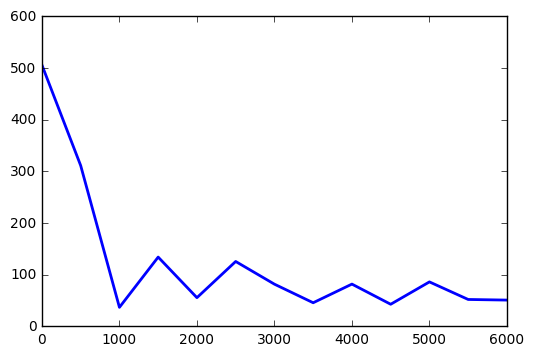

In [64]:
%matplotlib inline

import matplotlib.pyplot as plt

#let't store the cost at each epoch in order to plot it at the end

mycost = []
epoch = []

#we compute the graph now!

with tf.Session(graph=graph) as session:
    #initializing the graph variables
    tf.initialize_all_variables().run()
    print("Graph Variables Initialized!")
    
    for step in range(training_epochs):
        #calculate the offset for the mini-batch
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        #generate the mini-batch
        batch_data = train_dataset[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        
        #running the graph with the mini-batch data as the training dataset
        dummy, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        
        
        #printing partial results each display_steps times
        if(step % display_step == 0):
            mycost.append(l)
            epoch.append(step)
            print("Minibatch loss at step {}: {}".format(step,l))
            print("Minibatch accuracy: {}".format(accuracy(predictions,batch_labels)))
            print("Validation accuracy: {}".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {}".format(accuracy(test_prediction.eval(),test_labels)))
    
    plt.plot(epoch,mycost,linewidth=2)